## Imports

In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
import pandas as pd
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


## Preprocessing

In [2]:
%%time
# Open data files
path = "./data/"

train = pd.read_csv(path+'train.csv', encoding='iso-8859-1')[::]
test = pd.read_csv(path+'test.csv')
test_ticket_id = np.array(test['ticket_id'])

train = train.set_index('ticket_id')
test = test.set_index('ticket_id')

# Drop the violators who were found not responsible
train.dropna(subset=['compliance'], inplace=True)

# Drop some uninformative features
for column_name in ['inspector_name', 'violator_name',
                    'violation_zip_code', 'violation_street_number', 'violation_street_name',
                    'mailing_address_str_number', 'mailing_address_str_name', 'city',
                    'state', 'zip_code', 'non_us_str_code', 'country',
                    'violation_description',
                    'admin_fee', 'state_fee', 'late_fee']:
    test.drop(column_name, axis=1, inplace=True)



# Convert datetime columns into years/months/days
for column_name in ['ticket_issued_date', 'hearing_date']:
    print('Converting datetime to years/months/days...', column_name)
    
    # test
    day_time = pd.to_datetime(test[column_name])
    test.drop(column_name, axis=1, inplace=True)
    test[column_name+'_month'] = np.array(day_time.dt.month)
    test[column_name+'_year'] = np.array(day_time.dt.year)
    test[column_name+'_day'] = np.array(day_time.dt.day)
    test[column_name+'_dayofweek'] = np.array(day_time.dt.dayofweek)
    
    # train
    day_time = pd.to_datetime(train[column_name])
    train.drop(column_name, axis=1, inplace=True)
    train[column_name+'_month'] = np.array(day_time.dt.month)
    train[column_name+'_year'] = np.array(day_time.dt.year)
    train[column_name+'_day'] = np.array(day_time.dt.day)
    train[column_name+'_dayofweek'] = np.array(day_time.dt.dayofweek)

# Convert string columns to categorical
cols = test.select_dtypes(exclude=['float', 'int']).columns
len_train = len(train)
temp_concat = pd.concat((train[cols], test[cols]), axis=0)

# Some filtering on violation_code to make it more manageable
temp_concat['violation_code'] = temp_concat['violation_code'].apply(lambda x: x.split(' ')[0])
temp_concat['violation_code'] = temp_concat['violation_code'].apply(lambda x: x.split('(')[0])
temp_concat['violation_code'][temp_concat['violation_code'].apply(lambda x: x.find('-')<=0)] = np.nan

# Make all codes with < 10 occurrences null
counts = temp_concat['violation_code'].value_counts()
temp_concat['violation_code'][temp_concat['violation_code'].isin(counts[counts < 10].index)] = np.nan

for column_name in cols:
    print('Converting to categorical...', column_name, '# variables:', len(temp_concat[column_name].unique()))
    dummies = pd.get_dummies(temp_concat[column_name])
    temp_concat[dummies.columns] = dummies
    temp_concat.drop(column_name, axis=1, inplace=True)
    train.drop(column_name, axis=1, inplace=True)
    test.drop(column_name, axis=1, inplace=True)

train[temp_concat.columns] = temp_concat.loc[train.index]
test[temp_concat.columns] = temp_concat.loc[test.index]

features = list( test.columns )
target = ['compliance']

print("Number of features:", len(features))

<string>:2: DtypeWarning: Columns (11,12,31) have mixed types. Specify dtype option on import or set low_memory=False.


Converting datetime to years/months/days... ticket_issued_date
Converting datetime to years/months/days... hearing_date
Converting to categorical... agency_name # variables: 5
Converting to categorical... violation_code # variables: 72
Converting to categorical... disposition # variables: 8
Converting to categorical... grafitti_status # variables: 2
Number of features: 97
CPU times: user 4.87 s, sys: 1.48 s, total: 6.35 s
Wall time: 6.41 s


In [3]:
# TODO: Add this as a feature.
# from censusgeocode import CensusGeocode
# cg = CensusGeocode()

# def return_geoid(lon, lat):
#     # geoid = cg.address(address, city='Detroit', state='MI')
#     geoid = cg.coordinates(x=lon, y=lat)
#     try:
#        print(geoid[0]['Census Tracts'][0][u'GEOID'])
#     except:
#        print(lon, lat, geoid)
#     return geoid #int(geoid)

In [4]:
# Train Set
X = train[features]
y = np.array(train[target]).ravel()

# Normalize
mn = X.mean()
std = X.std()
X = (X - mn)/std

X = X.replace([np.inf, -np.inf], np.nan)
X[pd.isnull(X)] = 0

# Submissions Set
Xtest = (test[features] - mn) / std
Xtest = Xtest.replace([np.inf, -np.inf], np.nan)
Xtest[pd.isnull(Xtest)] = 0

## Evaluation

### Define Models

In [5]:
# Imports
from sklearn.linear_model import SGDClassifier, Perceptron
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble     import RandomForestClassifier
from sklearn.ensemble     import RandomForestRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

# Add classifiers
classifiers = {
    "ASGD": SGDClassifier(average=True),
    "SAG": LogisticRegression(solver='sag', tol=1e-1, C=1.e4 / train[features].shape[0]),
    "RF_R": RandomForestRegressor(max_depth=25),
    "GradBoost_C": GradientBoostingClassifier(learning_rate=0.05,
                                            max_features='auto',
                                            max_depth=2,
                                            min_samples_leaf=3,
                                            min_samples_split=4),
    "GradBoost_R": GradientBoostingRegressor(learning_rate=0.05,
                                            max_features='auto',
                                            max_depth=2,
                                            min_samples_leaf=3,
                                            min_samples_split=4),
    "VanillaGrad": GradientBoostingClassifier(),
    'MLP_C': MLPClassifier(),
    'MLP_R': MLPRegressor(),
#     'MLP_C_D': MLPClassifier(hidden_layer_sizes=(50, 75, 75, 50)),
#     'MLP_R_D': MLPRegressor(hidden_layer_sizes=(50, 75, 75, 50)),
    'MLP_R_D_shallow': MLPRegressor(hidden_layer_sizes=(25, 25, 25, 25, 25, 25, 25, 25)),
    "RF_R": RandomForestRegressor(n_estimators=25)
}

# Create Train/Test split for evaluation.
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

/Users/thealex/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Evaluate with K-Fold Cross Validation

In [6]:
# Imports / helper functions
from sklearn.metrics import roc_auc_score

def roc_auc_scorer(y_true, y_pred):
    return roc_auc_score(y_true, y_pred[:, 1])

def accuracy_with_rescaling(y, y_pred):
    """Potentially depricated now that we understand that we shouldn't be rounding output"""
    y_pred = np.round((y_pred - y_pred.min()) / y_pred.max())
    return sum(y_pred == y) / len(y)

In [7]:
%%time

scores = dict()
# Select the model
for classifier_type in classifiers.keys():
    # Train classifier
    clf = classifiers[classifier_type]
    # Score classifier
    # If using cross_val_score, there is no need for train test split.
    try:
        # For the classifiers -- needs_proba=True and alternative scorer for classifiers
        model_score = cross_val_score(clf, X, y, cv=5, n_jobs=-1, scoring=make_scorer(roc_auc_scorer, needs_proba=True))
    except AttributeError:
        # For the regressors
        model_score = cross_val_score(clf, X, y, cv=5, n_jobs=-1, scoring=make_scorer(roc_auc_score))
    # Record score
    scores[classifier_type] = model_score
    display(pd.DataFrame({classifier_type: scores[classifier_type]}))

scores = pd.DataFrame(data=scores)
display(scores.describe())

,SAG
0,0.769031
1,0.763832
2,0.821832
3,0.764281
4,0.707517


,ASGD
0,0.534559
1,0.587398
2,0.584282
3,0.504277
4,0.551401


,GradBoost_R
0,0.765209
1,0.811955
2,0.811220
3,0.764734
4,0.778039


,GradBoost_C
0,0.778124
1,0.778320
2,0.822727
3,0.768449
4,0.761029


,MLP_R_D_shallow
0,0.766821
1,0.786088
2,0.803277
3,0.758019
4,0.748486


,MLP_R
0,0.771724
1,0.768531
2,0.774225
3,0.714001
4,0.743486


,MLP_C
0,0.784535
1,0.744991
2,0.773270
3,0.729851
4,0.716612


,RF_R
0,0.712114
1,0.773555
2,0.785296
3,0.710713
4,0.733373


,VanillaGrad
0,0.687899
1,0.716947
2,0.758335
3,0.661288
4,0.752495


,ASGD,GradBoost_C,GradBoost_R,MLP_C,MLP_R,MLP_R_D_shallow,RF_R,SAG,VanillaGrad
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.552384,0.781730,0.786231,0.749852,0.754393,0.772538,0.743010,0.765299,0.715393
std,0.034916,0.024033,0.023755,0.028635,0.025710,0.022082,0.034683,0.040472,0.041552
min,0.504277,0.761029,0.764734,0.716612,0.714001,0.748486,0.710713,0.707517,0.661288
25%,0.534559,0.768449,0.765209,0.729851,0.743486,0.758019,0.712114,0.763832,0.687899
50%,0.551401,0.778124,0.778039,0.744991,0.768531,0.766821,0.733373,0.764281,0.716947
75%,0.584282,0.778320,0.811220,0.773270,0.771724,0.786088,0.773555,0.769031,0.752495
max,0.587398,0.822727,0.811955,0.784535,0.774225,0.803277,0.785296,0.821832,0.758335


CPU times: user 18 s, sys: 2.88 s, total: 20.8 s
Wall time: 8min 40s


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

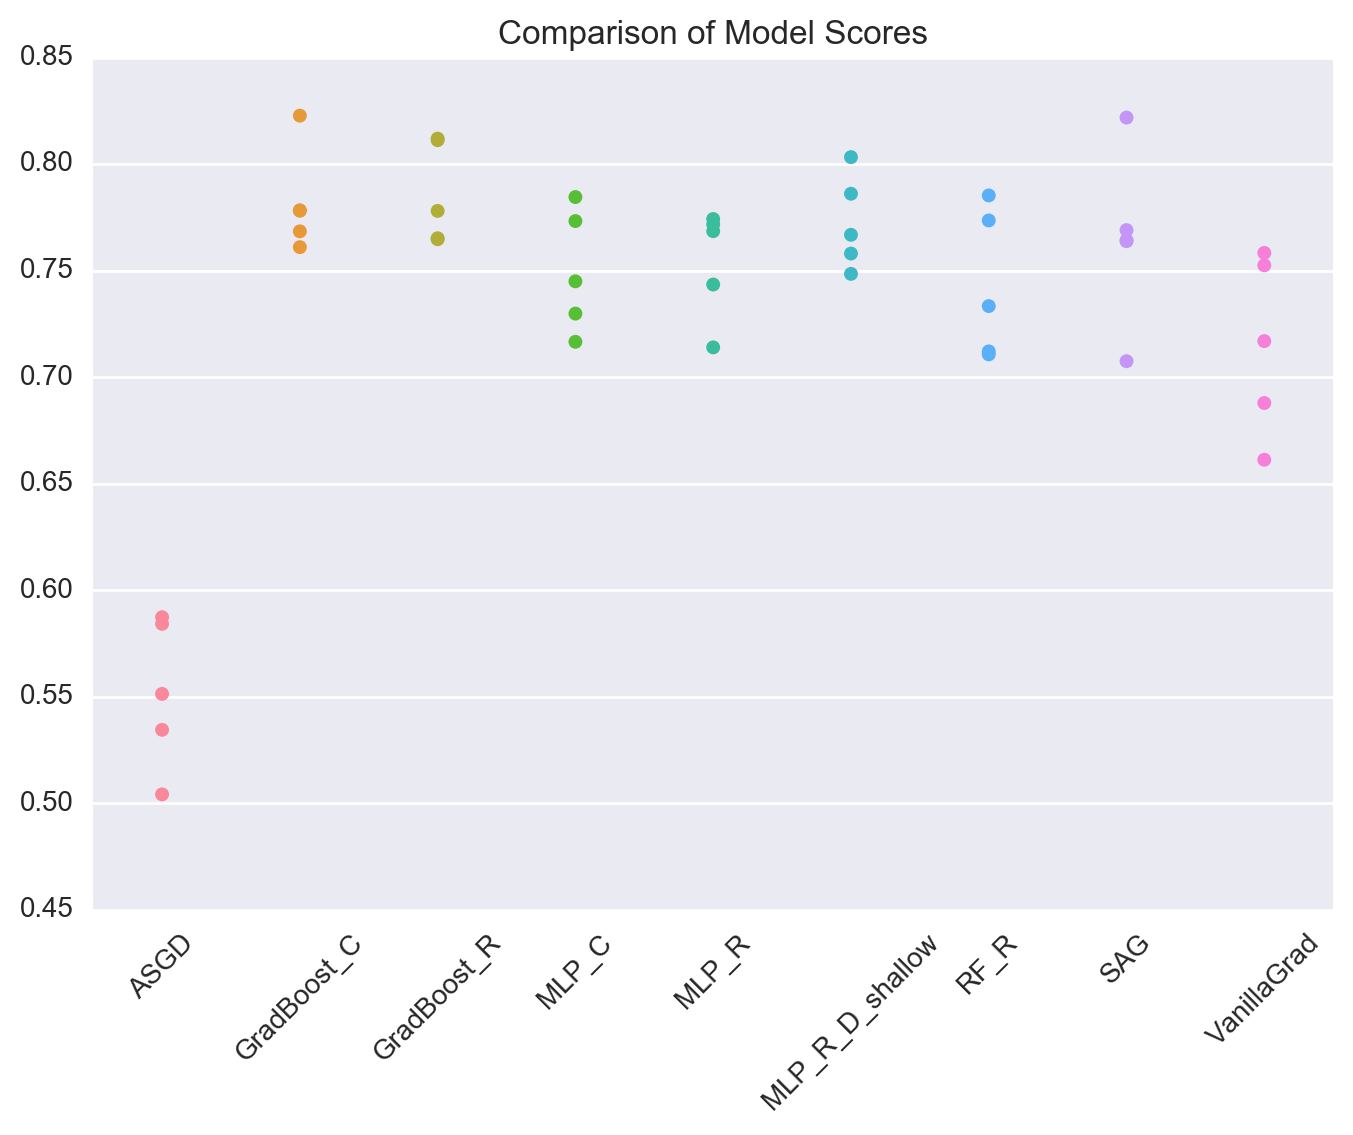

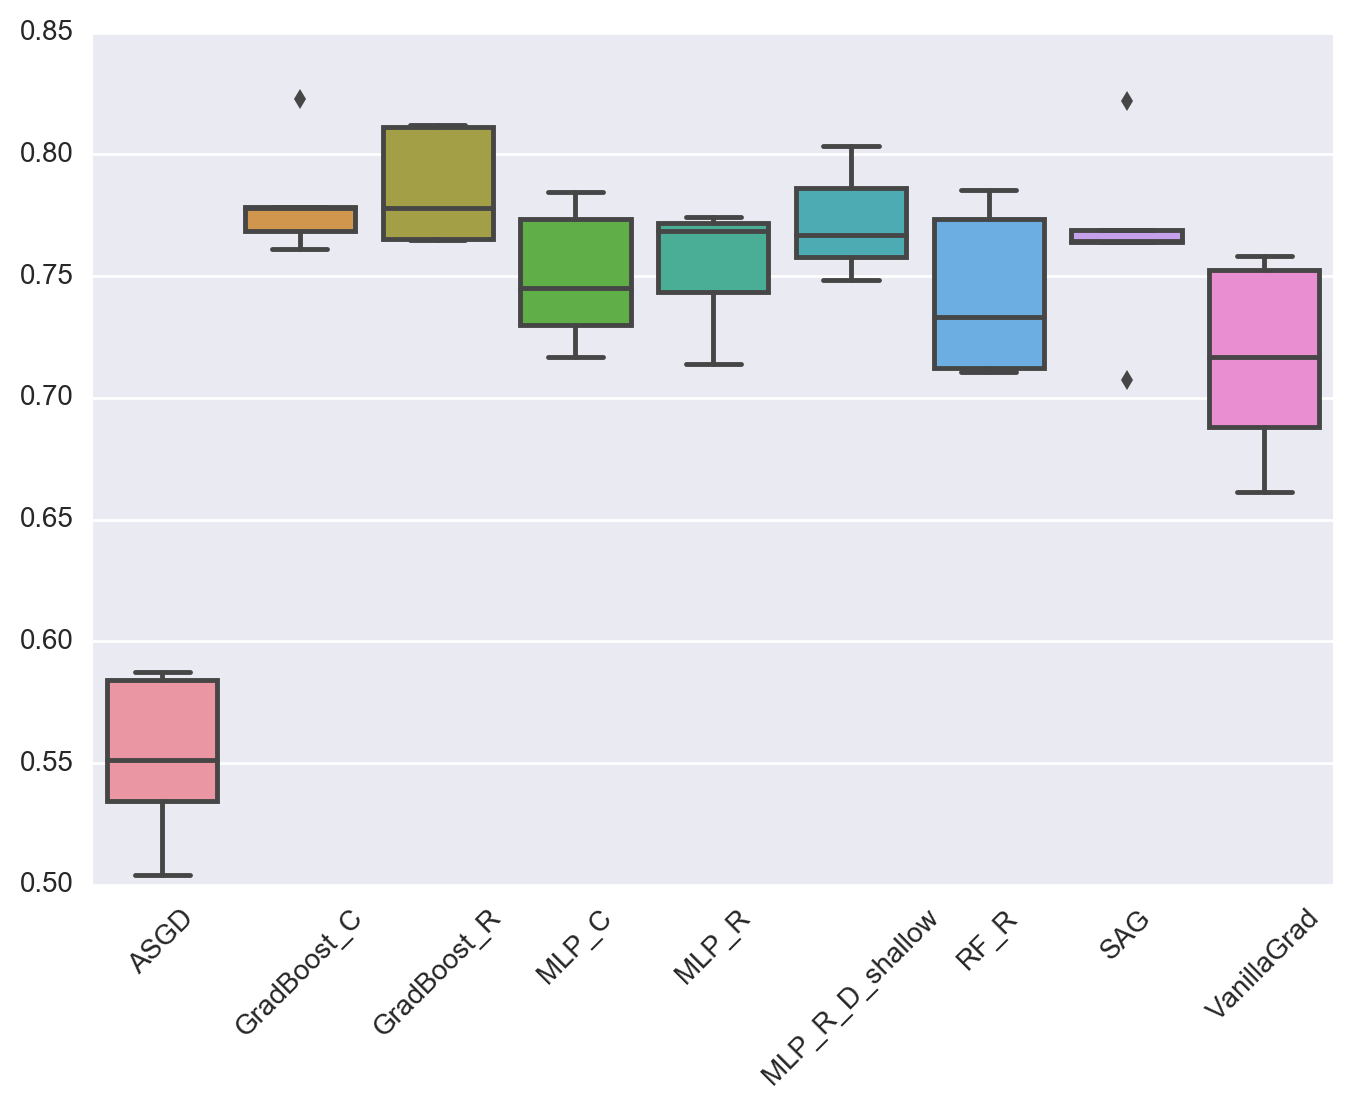

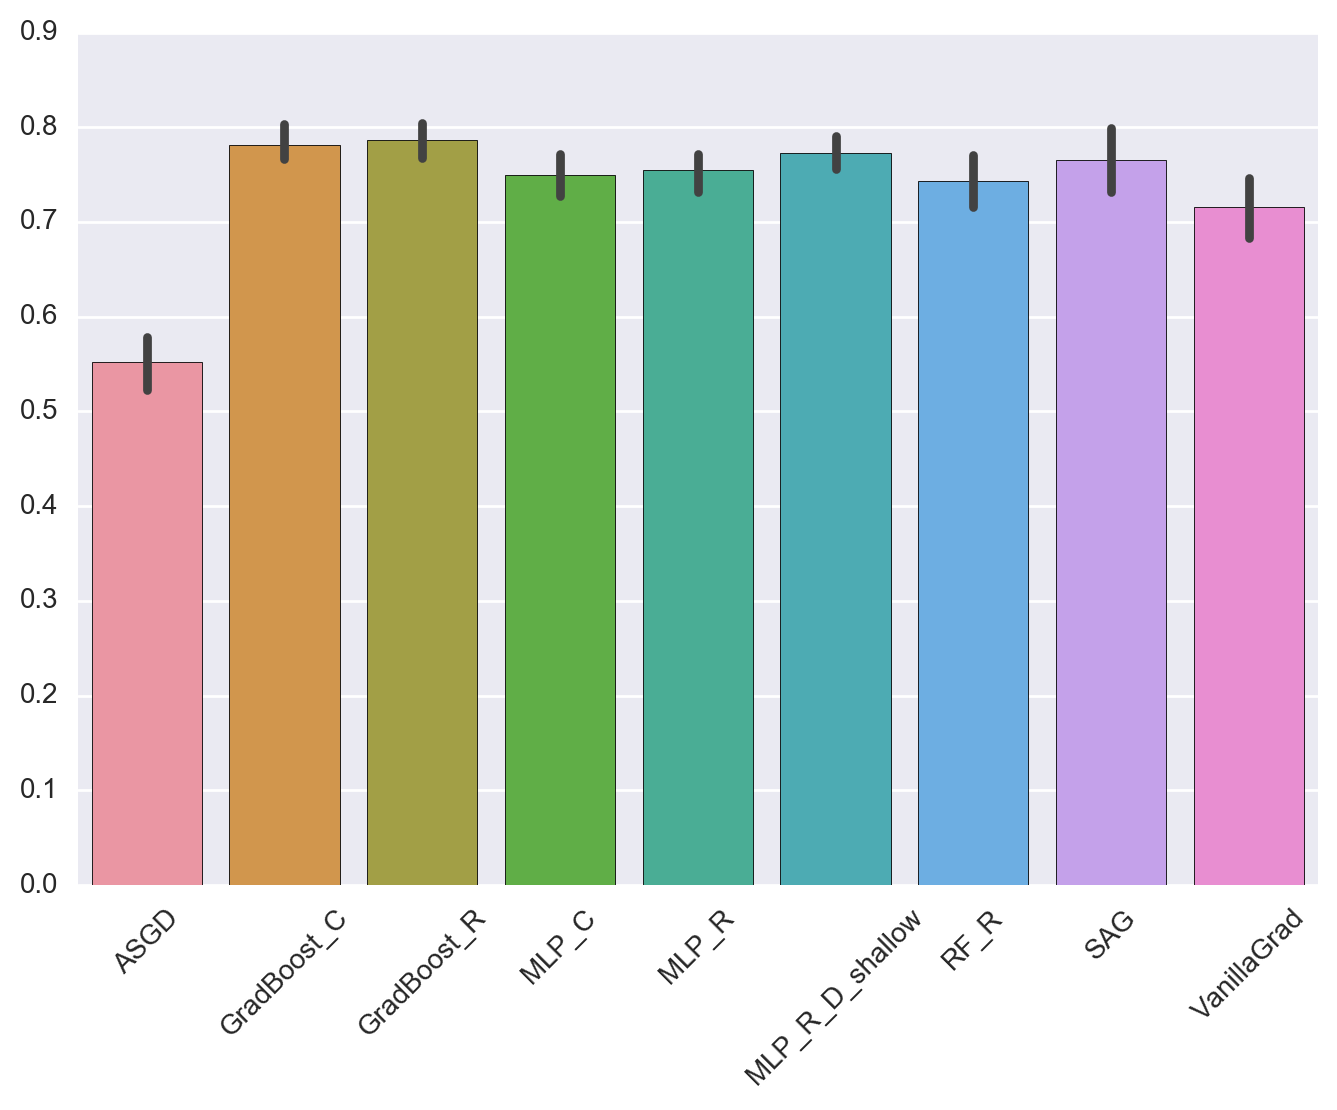

In [8]:
plt.figure()
sns.stripplot(data=scores)
plt.xticks(rotation=45)
plt.title('Comparison of Model Scores')

plt.figure()
sns.boxplot(data=scores)
plt.xticks(rotation=45)
plt.figure()
sns.barplot(data=scores)
plt.xticks(rotation=45)

In [9]:
%%time
## Submission
def make_submission(model_name, clf):
    print('Fitting %s ...' % model_name)
    # Train classifier
    clf.fit(X, y)

    # Predict
    print('Generating Predictions ...')
    try:
        print("A Classifier!")
        # For classifiers, we want the predicted probabilities (for label=True)
        y_pred = clf.predict_proba(Xtest)[:, 1]
        print(y_pred)
    except AttributeError:
        print("A Regressor!")
        # If regressor, get the scaled predictions
        y_pred = np.array(clf.predict(Xtest))
        # If output is not in range [0..1], this converts to [0..1]
        y_pred = y_pred - y_pred.min()
        y_pred = y_pred / y_pred.max()
        print(y_pred)



    # Save to CSV
    print('Saving to CSV ...')
    df = {"ticket_id":test_ticket_id, "compliance":y_pred}
    df = pd.DataFrame(df, columns=["ticket_id", "compliance"])
    df.to_csv("./data/submission_%s.csv" % model_name, index=False)
    print('finished!')
    print('---------------------')

def make_all_submissions(classifiers):
    """classifiers: A dictionary of classifier name keys and sklearn classifier value pairs"""
    for model_name, clf in classifiers.items():
        make_submission(model_name, clf)

# Make all submissions
make_all_submissions(classifiers)

# Make individual submission
# target_clf = "MLP_C_D"
# make_submission(target_clf, classifiers[target_clf])

Fitting SAG ...
Generating Predictions ...
A Classifier!
[ 0.17102797  0.05684336  0.08865537 ...,  0.07636108  0.07636108
  0.06343012]
Saving to CSV ...
finished!
---------------------
Fitting ASGD ...
Generating Predictions ...
A Classifier!
A Regressor!
[ 0.  0.  0. ...,  0.  0.  0.]
Saving to CSV ...
finished!
---------------------
Fitting GradBoost_R ...
Generating Predictions ...
A Classifier!
A Regressor!
[ 0.08602857  0.01555803  0.04654397 ...,  0.04532445  0.04532445
  0.04532445]
Saving to CSV ...
finished!
---------------------
Fitting GradBoost_C ...
Generating Predictions ...
A Classifier!
[ 0.10705173  0.03291149  0.07018632 ...,  0.06769831  0.06769831
  0.06769831]
Saving to CSV ...
finished!
---------------------
Fitting MLP_R_D_shallow ...
Generating Predictions ...
A Classifier!
A Regressor!
[ 0.19200764  0.05854883  0.08179133 ...,  0.07454094  0.07454094
  0.07165442]
Saving to CSV ...
finished!
---------------------
Fitting MLP_R ...
Generating Predictions ...
A